In [1]:
import pandas
import datetime
import numpy
from sklearn import linear_model
import scipy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib import rcParams

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2000.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 250
mlatCutOffUpper = 70.
probOccCutoff = 0.2

In [3]:
velGmagDF = pandas.read_csv("../data/processed-vels-geomag.txt", sep=' ')
velGmagDF = velGmagDF.drop('Unnamed: 0', axis=1)
# Discard unwanted values
# We'll only consider those velocities 
# which lie between 0 and 2500 m/s
# and located below 70 MLAT
velGmagDF = velGmagDF[ (velGmagDF["vSaps"] > velCutoffLower) \
                        & (velGmagDF["vSaps"] < velCutoffUpper)\
                       ].reset_index(drop=True)
velGmagDF = velGmagDF[ velGmagDF["MLAT"] < mlatCutOffUpper ].reset_index(drop=True)
# Now filter out velocities which have very few rate of occ.
# We calculat the prob and remove every measurement below 0.2 prob of occ.
mlatMLTDstCountDF = velGmagDF.groupby( ["MLAT", "normMLT", "dst_bin"] )["vSaps"].count().reset_index()
mlatMLTDstCountDF.columns = [ "MLAT", "normMLT", "dst_bin", "count" ]
dstMaxCntDF = mlatMLTDstCountDF.groupby( ["dst_bin"] )["count"].max().reset_index()
dstMaxCntDF.columns = [ "dst_bin", "maxCntDst" ]
mlatMLTDstCountDF = pandas.merge( mlatMLTDstCountDF, dstMaxCntDF, on=[ "dst_bin" ] )
mlatMLTDstCountDF["probOcc"] = mlatMLTDstCountDF["count"]/mlatMLTDstCountDF["maxCntDst"]
mlatMLTDstCountDF = mlatMLTDstCountDF[ mlatMLTDstCountDF["probOcc"] > probOccCutoff ].reset_index(drop=True)
# Filter out MLATs and MLTs (at the Dst bins)
# where number of measurements is low. We do
# this by merging the mlatMLTDstCountDF with velDF.
velGmagDF = pandas.merge( velGmagDF,\
                         mlatMLTDstCountDF,\
                         on=[ "MLAT", "normMLT", "dst_bin" ] )
velGmagDF = velGmagDF[ [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "dst_index", "count", "maxCntDst" ] ]
# Divide the velocities into bins
velBins = [ v for v in range(0,int(velCutoffUpper)+100,100) ]
velGmagDF = pandas.concat( [ velGmagDF, \
                    pandas.cut( velGmagDF["vSaps"], \
                               bins=velBins ) ], axis=1 )
velGmagDF.columns = [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "dst_index", "count",\
                         "maxCntDst", "vel_bin" ]
# velGmagDF.head()
# Get a DF with mean Dst in each bin
dstMeanDF = velGmagDF.groupby( ["dst_bin"] ).mean()["dst_index"].astype(int).reset_index()
dstMeanDF.columns = [ "dst_bin", "dst_mean" ]
velGmagDF = pandas.merge( velGmagDF, dstMeanDF, on=["dst_bin"] )
velGmagDF = velGmagDF.sort( ["dst_mean"], ascending=False ).reset_index(drop=True)
maxSapsVel = numpy.ceil( velGmagDF["vSaps"].max()/1000 ) * 1000.
velGmagDF["norm_vels"] = velGmagDF["vSaps"]/maxSapsVel
velGmagDF.head()

,normMLT,MLAT,vSaps,azim,dst_bin,dst_index,count,maxCntDst,vel_bin,dst_mean,norm_vels
0,1,58,927.34,-12.52,"(-10, 10]",-6,293,508,"(900, 1000]",-3,0.463670
1,-3,61,755.23,-17.91,"(-10, 10]",-8,277,508,"(700, 800]",-3,0.377615
2,-3,61,743.78,-17.19,"(-10, 10]",-8,277,508,"(700, 800]",-3,0.371890
3,-3,61,800.52,-14.51,"(-10, 10]",-8,277,508,"(800, 900]",-3,0.400260
4,-3,61,535.88,-19.86,"(-10, 10]",-8,277,508,"(500, 600]",-3,0.267940


In [4]:
azimFullLocMeanDF = velGmagDF.groupby( [ "normMLT", "MLAT", "dst_bin", "dst_mean" ] ).mean()[ "azim" ].reset_index()
azimMLTMeanDF = velGmagDF.groupby( [ "normMLT", "dst_bin", "dst_mean" ] ).mean()[ "azim" ].reset_index()
azimMLTMeanDF.columns = [ "normMLT", "dst_bin", "dst_mean", "azim_mean" ]
azimMLATMeanDF = velGmagDF.groupby( [ "MLAT", "dst_bin", "dst_mean" ] ).mean()[ "azim" ].reset_index()
azimMLATMeanDF.columns = [ "MLAT", "dst_bin", "dst_mean", "azim_mean" ]
azimMLTMeanDF.head()

,normMLT,dst_bin,dst_mean,azim_mean
0,-7,"(-150, -75]",-98,-14.620698
1,-6,"(-150, -75]",-98,-13.667246
2,-6,"(-50, -25]",-36,-14.194459
3,-6,"(-75, -50]",-57,-14.486663
4,-5,"(-150, -75]",-98,-12.128485


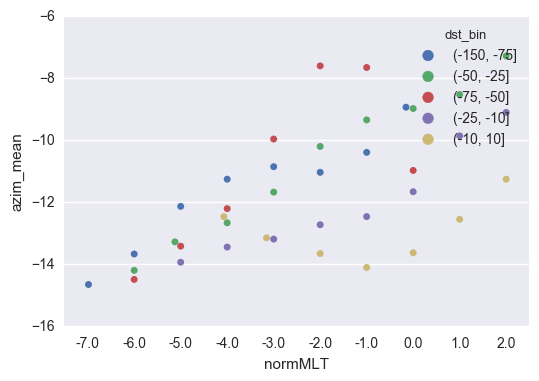

In [5]:
selDF = azimMLTMeanDF#[ azimMLTMeanDF["dst_bin"] == "(-10, 10]" ] 
sns.swarmplot( x="normMLT", y="azim_mean", hue="dst_bin",\
              data=selDF)

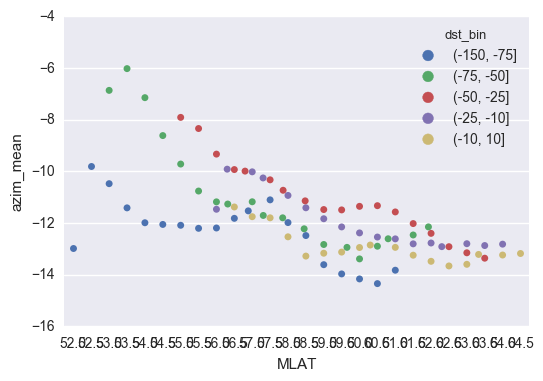

In [6]:
selDF = azimMLATMeanDF#[ azimMLATMeanDF["dst_bin"] == "(-50, -25]" ] 
sns.swarmplot( x="MLAT", y="azim_mean", hue="dst_bin",\
              data=selDF)

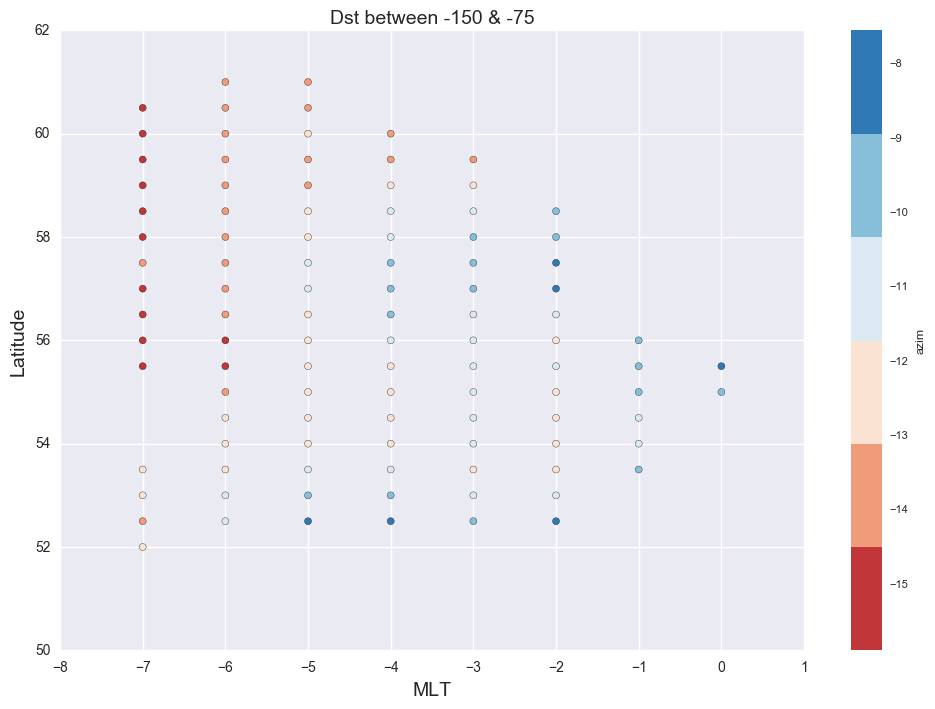

In [7]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)

sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("RdBu"))
# (-150,-75]
azim15075DF = azimFullLocMeanDF[ azimFullLocMeanDF["dst_bin"] == "(-150, -75]" ]
azim15075DF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=25, cmap=seaMap, ax=ax1, sharex=True)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )

In [8]:
# Calculate the standard deviation in azims by MLT and Dst
azimMLTStdDF = velGmagDF.groupby( [ "normMLT", "dst_bin", "dst_mean" ] ).std()[ "azim" ].reset_index()
azimMLTStdDF.columns = [ "normMLT", "dst_bin", "dst_mean", "azim_std" ]
azimMLTMeanDF = pandas.merge( azimMLTMeanDF, azimMLTStdDF, on=[ "normMLT", "dst_bin", "dst_mean" ] )
azimMLTMeanDF.head()

,normMLT,dst_bin,dst_mean,azim_mean,azim_std
0,-7,"(-150, -75]",-98,-14.620698,5.137291
1,-6,"(-150, -75]",-98,-13.667246,5.708887
2,-6,"(-50, -25]",-36,-14.194459,3.867985
3,-6,"(-75, -50]",-57,-14.486663,4.249787
4,-5,"(-150, -75]",-98,-12.128485,7.129653


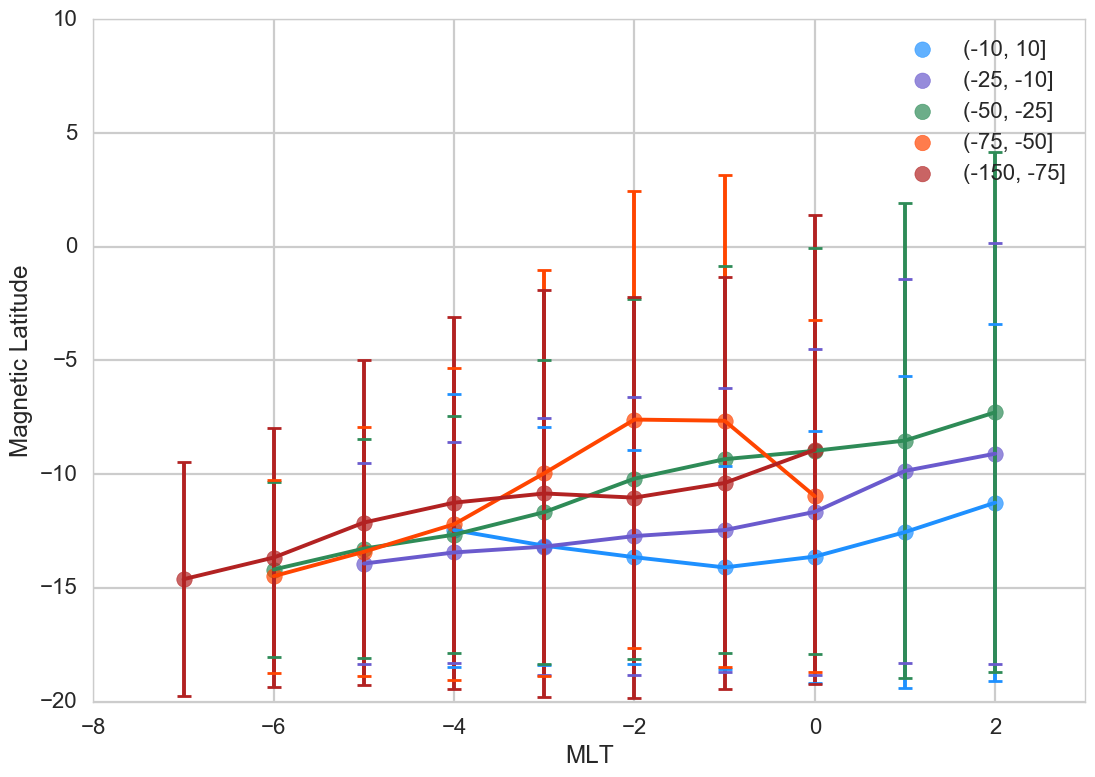

In [9]:
sns.set_style("whitegrid")
sns.set_context("poster")


azimMLTMeanDF["azim_std"] = azimMLTMeanDF["azim_std"].fillna(0.5)
azimMLTMeanDF = azimMLTMeanDF.sort(["normMLT"])
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
# azimMLTMeanDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]

plt.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"],
            azimMLTMeanDF['azim_mean'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
plt.errorbar(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"],\
             azimMLTMeanDF['azim_mean'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"],\
             yerr=azimMLTMeanDF['azim_std'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"], \
             color='dodgerblue', label='', capthick=2., capsize=5.)
# plt.xticks(azimMLTMeanDF['normMLT'].unique(), \
#            azimMLTMeanDF['mltStr'].unique(), size='small')

###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######


###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
# azimMLTMeanDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]

plt.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"],
            azimMLTMeanDF['azim_mean'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"],
            marker='o',
            color='slateblue',
            alpha=0.7,
            s = 124,
            label='(-25, -10]')
plt.errorbar(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"],\
             azimMLTMeanDF['azim_mean'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"],\
             yerr=azimMLTMeanDF['azim_std'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"], \
             color='slateblue', label='', capthick=2., capsize=5.)
# plt.xticks(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"], \
#            azimMLTMeanDF['mltStr'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"], size='small')
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######



###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######

plt.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],
            azimMLTMeanDF['azim_mean'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],
            marker='o',
            color='seagreen',
            alpha=0.7,
            s = 124,
            label='(-50, -25]')

plt.errorbar(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],\
             azimMLTMeanDF['azim_mean'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],\
             yerr=azimMLTMeanDF['azim_std'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],\
             color='seagreen', label='', capthick=2., capsize=5.)
# plt.xticks(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"], \
#            azimMLTMeanDF['mltStr'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"], size='small')

###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######



# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######

plt.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],
            azimMLTMeanDF['azim_mean'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],
            marker='o',
            color='orangered',
            alpha=0.7,
            s = 124,
            label='(-75, -50]')
plt.errorbar(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],\
             azimMLTMeanDF['azim_mean'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],\
             yerr=azimMLTMeanDF['azim_std'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],\
             color='orangered', label='', capthick=2., capsize=5.)
# plt.xticks(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"], \
#            azimMLTMeanDF['mltStr'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"], size='small')

###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######



# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######

plt.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"],
            azimMLTMeanDF['azim_mean'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124,
            label='(-150, -75]')
plt.errorbar(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"],\
             azimMLTMeanDF['azim_mean'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"],\
             yerr=azimMLTMeanDF['azim_std'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"], \
             color='firebrick', label='', capthick=2., capsize=5.)
# plt.xticks(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"], \
#            azimMLTMeanDF['mltStr'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"], size='small')

# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
           
plt.xlim( [-8,3] )
plt.ylim( [-20,10] )
plt.xlabel("MLT")
plt.ylabel("Magnetic Latitude")
plt.legend()
plt.savefig("../figs/meanStdAzim.pdf",bbox_inches='tight')

In [10]:
# We'll fit Azim as a linear function of MLT and Dst
def azim_fit_func((mlt, dst), a1mlt_azim, a2mlt_azim,\
               b1mlt_azim, b2mlt_azim):
    
    
    a_azim = a1mlt_azim + a2mlt_azim * dst
    b_azim = b1mlt_azim + b2mlt_azim * dst
    # func
    azim = a_azim + b_azim*(mlt)
    
    return azim.ravel()

def azim_pred_func(mlt, dst):
    
    initGuess = ( 1, 1, 10, 10 )
    popt2, pcov2 = curve_fit(azim_fit_func, (azimMLTMeanDF['normMLT'].T, azimMLTMeanDF["dst_mean"].T),\
                             azimMLTMeanDF['azim_mean'], p0=initGuess)    
    print popt2
    print "-----------"
    print pcov2
    ( a1mlt_azim, a2mlt_azim,\
               b1mlt_azim, b2mlt_azim ) = tuple( popt2.tolist() )
    
    # model shape parameters
    # mlt
    a_azim = a1mlt_azim + a2mlt_azim * dst
    b_azim = b1mlt_azim + b2mlt_azim * dst
    # func
    azim = a_azim + b_azim*(mlt)
    
    return azim.ravel()

azimMLTMeanDF["azim_pred"] = azim_pred_func( azimMLTMeanDF["normMLT"], azimMLTMeanDF["dst_mean"] )

[ -1.18517883e+01  -4.55247673e-02   4.23702572e-01  -6.12919018e-03]
-----------
[[  1.61342262e-01   2.78311613e-03   3.19422777e-02   5.53564674e-04]
 [  2.78311613e-03   8.82174940e-05   5.44916034e-04   1.76807551e-05]
 [  3.19422777e-02   5.44916034e-04   2.03656745e-02   2.93402447e-04]
 [  5.53564674e-04   1.76807551e-05   2.93402447e-04   6.86837619e-06]]


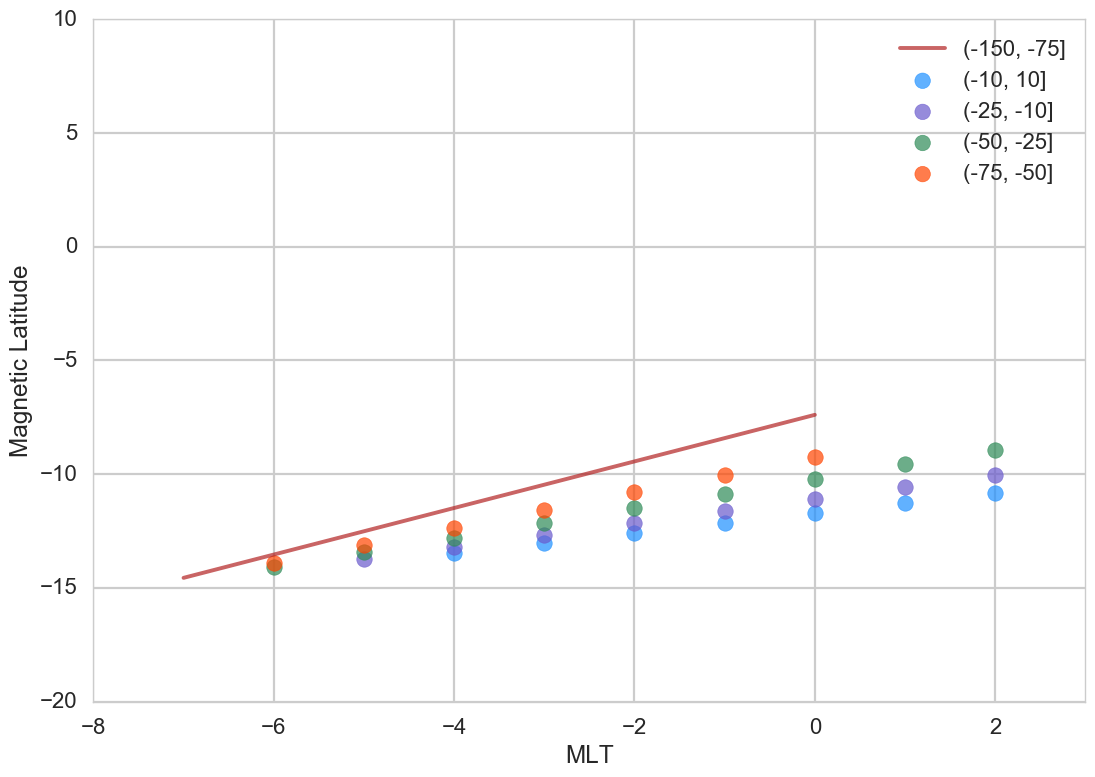

In [11]:
sns.set_style("whitegrid")
sns.set_context("poster")


azimMLTMeanDF["azim_std"] = azimMLTMeanDF["azim_std"].fillna(0.5)
azimMLTMeanDF = azimMLTMeanDF.sort(["normMLT"])
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
# azimMLTMeanDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]

plt.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"],
            azimMLTMeanDF['azim_pred'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
# plt.xticks(azimMLTMeanDF['normMLT'].unique(), \
#            azimMLTMeanDF['mltStr'].unique(), size='small')

###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######


###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
# azimMLTMeanDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]

plt.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"],
            azimMLTMeanDF['azim_pred'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"],
            marker='o',
            color='slateblue',
            alpha=0.7,
            s = 124,
            label='(-25, -10]')
# plt.xticks(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"], \
#            azimMLTMeanDF['mltStr'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"], size='small')
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######



###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######

plt.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],
            azimMLTMeanDF['azim_pred'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],
            marker='o',
            color='seagreen',
            alpha=0.7,
            s = 124,
            label='(-50, -25]')

# plt.xticks(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"], \
#            azimMLTMeanDF['mltStr'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"], size='small')

###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######



# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######
# ###### PLOT Dst-bin (-75, -50] ######

plt.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],
            azimMLTMeanDF['azim_pred'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],
            marker='o',
            color='orangered',
            alpha=0.7,
            s = 124,
            label='(-75, -50]')
# plt.xticks(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"], \
#            azimMLTMeanDF['mltStr'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"], size='small')

###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######



# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######

plt.plot(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"],
            azimMLTMeanDF['azim_pred'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"] ,
            color='firebrick',
            alpha=0.7,
            label='(-150, -75]')

# plt.xticks(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"], \
#            azimMLTMeanDF['mltStr'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"], size='small')

# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
           
plt.xlim( [-8,3] )
plt.ylim( [-20,10] )
plt.xlabel("MLT")
plt.ylabel("Magnetic Latitude")
plt.legend()
plt.savefig("../figs/meanStdAzim.pdf",bbox_inches='tight')

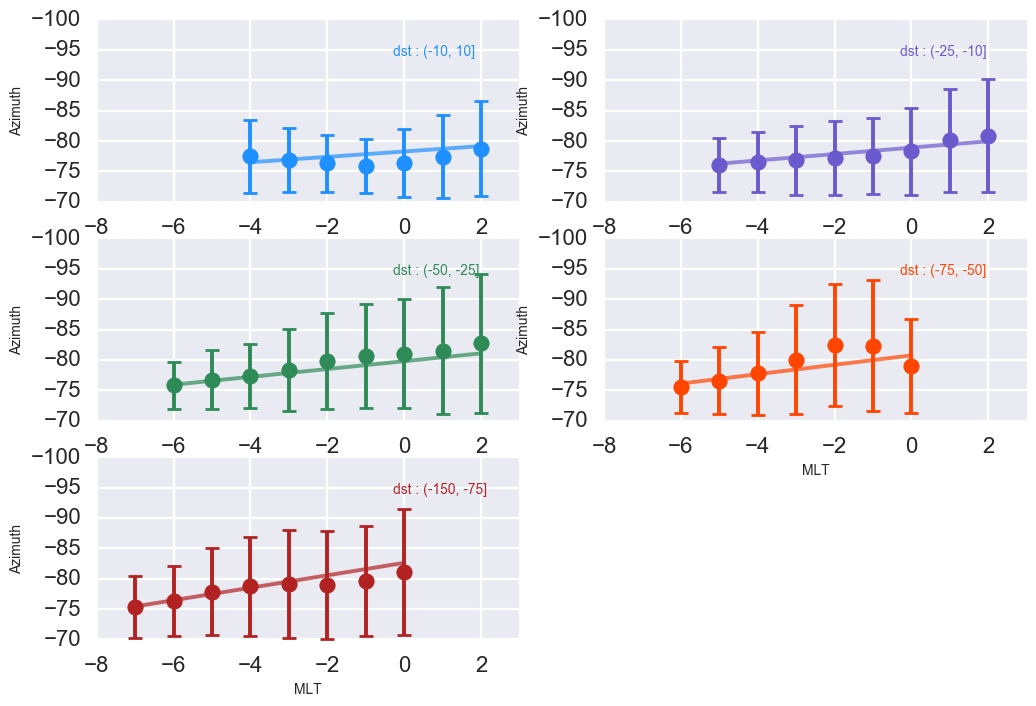

In [16]:
azimMLTMeanDF["azim_mean_west_acutal_direction"] = -90. - azimMLTMeanDF["azim_mean"]
azimMLTMeanDF["azim_pred_acutal_direction"] = -90. - azimMLTMeanDF["azim_pred"]

sns.set_style("darkgrid")
sns.set_context("poster")

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

azimMLTMeanDF["azim_std"] = azimMLTMeanDF["azim_std"].fillna(0.5)
azimMLTMeanDF = azimMLTMeanDF.sort(["normMLT"])
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
# azimMLTMeanDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]

ax1.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"],
            azimMLTMeanDF['azim_mean_west_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 124)
ax1.plot(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"],
            azimMLTMeanDF['azim_pred_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"],
            color='dodgerblue',
            alpha=0.7)
ax1.errorbar(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"],\
             azimMLTMeanDF['azim_mean_west_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"],\
             yerr=azimMLTMeanDF['azim_std'][azimMLTMeanDF['dst_bin'] == "(-10, 10]"], \
             color='dodgerblue', fmt='o', label='', capthick=2., capsize=5.)
ax1.set_xlim( [-8,3] )
ax1.set_ylim( [-70,-100] )
ax1.set_ylabel("Azimuth", fontsize=10)
ax1.text(0.7, 0.8,  "dst : (-10, 10]",
            transform=ax1.transAxes,
            color='dodgerblue', fontsize=10)
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######
###### PLOT Dst-bin (-10, 10] ######


###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
# azimMLTMeanDF['normLAT'] = [x-57.5 for x in sapsModelDF['sapsLat']]

ax2.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"],
            azimMLTMeanDF['azim_mean_west_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"],
            marker='o',
            color='slateblue',
            alpha=0.7,
            s = 124)
ax2.plot(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"],
            azimMLTMeanDF['azim_pred_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"],
            color='slateblue',
            alpha=0.7)
ax2.errorbar(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"],\
             azimMLTMeanDF['azim_mean_west_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"],\
             yerr=azimMLTMeanDF['azim_std'][azimMLTMeanDF['dst_bin'] == "(-25, -10]"], \
             color='slateblue', fmt='o', label='', capthick=2., capsize=5.)
ax2.set_xlim( [-8,3] )
ax2.set_ylim( [-70,-100] )
ax2.set_ylabel("Azimuth", fontsize=10)
ax2.text(0.7, 0.8,  "dst : (-25, -10]",
            transform=ax2.transAxes,
            color='slateblue', fontsize=10)
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######
###### PLOT Dst-bin (-25, -10] ######



###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######

ax3.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],
            azimMLTMeanDF['azim_mean_west_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],
            marker='o',
            color='seagreen',
            alpha=0.7,
            s = 124)

ax3.plot(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],
            azimMLTMeanDF['azim_pred_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],
            color='seagreen',
            alpha=0.7)

ax3.errorbar(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],\
             azimMLTMeanDF['azim_mean_west_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],\
             yerr=azimMLTMeanDF['azim_std'][azimMLTMeanDF['dst_bin'] == "(-50, -25]"],\
             color='seagreen', fmt='o', label='', capthick=2., capsize=5.)
ax3.set_xlim( [-8,3] )
ax3.set_ylim( [-70,-100] )
ax3.set_ylabel("Azimuth", fontsize=10)
ax3.text(0.7, 0.8,  "dst : (-50, -25]",
            transform=ax3.transAxes,
            color='seagreen', fontsize=10)
###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######
###### PLOT Dst-bin (-50, -25] ######



###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######

ax4.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],
            azimMLTMeanDF['azim_mean_west_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],
            marker='o',
            color='orangered',
            alpha=0.7,
            s = 124,)
ax4.plot(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],
            azimMLTMeanDF['azim_pred_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],
            color='orangered',
            alpha=0.7,)
ax4.errorbar(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],\
             azimMLTMeanDF['azim_mean_west_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],\
             yerr=azimMLTMeanDF['azim_std'][azimMLTMeanDF['dst_bin'] == "(-75, -50]"],\
             color='orangered', fmt='o', label='', capthick=2., capsize=5.)
ax4.set_xlim( [-8,3] )
ax4.set_ylim( [-70,-100] )

ax4.set_xlabel("MLT", fontsize=10)
ax4.set_ylabel("Azimuth", fontsize=10)
ax4.text(0.7, 0.8,  "dst : (-75, -50]",
            transform=ax4.transAxes,
            color='orangered', fontsize=10)
###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######
###### PLOT Dst-bin (-75, -50] ######



# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######
# ###### PLOT Dst-bin (-150, -75] ######

ax5.scatter(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"],
            azimMLTMeanDF['azim_mean_west_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124,
            label='(-150, -75]')
ax5.plot(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"],
            azimMLTMeanDF['azim_pred_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"] ,
            color='firebrick',
            alpha=0.7,
            label='(-150, -75]')
ax5.errorbar(azimMLTMeanDF['normMLT'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"],\
             azimMLTMeanDF['azim_mean_west_acutal_direction'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"],\
             yerr=azimMLTMeanDF['azim_std'][azimMLTMeanDF['dst_bin'] == "(-150, -75]"], \
             color='firebrick', fmt='o', label='', capthick=2., capsize=5.)
ax5.set_xlim( [-8,3] )
ax5.set_ylim( [-70,-100] )
ax5.text(0.7, 0.8,  "dst : (-150, -75]",
            transform=ax5.transAxes,
            color='firebrick', fontsize=10)
###### PLOT Dst-bin (-150, -75] ######
###### PLOT Dst-bin (-150, -75] ######
###### PLOT Dst-bin (-150, -75] ######

ax5.set_xlabel("MLT", fontsize=10)
ax5.set_ylabel("Azimuth", fontsize=10)
# plt.legend()
plt.savefig("../figs/FittedAzim.pdf",bbox_inches='tight')